In [0]:
import torch
import pdb
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.autograd import Function
import time
from torch.distributions.relaxed_bernoulli import RelaxedBernoulli,LogitRelaxedBernoulli
import numpy as np


def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
      tensor = tensor.sign()
      tensor[tensor==0] = 1
      return tensor
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

def sample2(mu, log_sigma2):
    eps = torch.randn_like(mu)
    s = mu + torch.exp(log_sigma2 / 2) * eps
    return s
  
  
def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape).cuda()
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits)/temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y
  
def sampling(mu,sig):
  x = Normal(mu,sig)

  p = 1 - x.cdf(0)

  return p



import torch.nn._functions as tnnf



    
class PBinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(PBinarizeLinear, self).__init__(*kargs, **kwargs)


    def forward(self, input):

      
      
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()  
            
        self.weight.data=Binarize(self.weight.org)

        theta = torch.tanh(self.weight)

        if input.size(1) != 784:
          mu = nn.functional.linear(input,theta)
          left = input**2 - (1- input**2)
          right = theta**2 - (1-theta**2)
          sigma = 1 - nn.functional.linear(left,right)
        else:

          mu = nn.functional.linear(input,theta)       
          sigma = nn.functional.linear(input**2,1-(theta**2))
        

        m = mu.mean(0,True)
        
        v = sigma.var(0,True)
     
        mu = 0.5*(mu-m)/((v+(0.0001)).sqrt()+0.5)
        sigma = 0.5**2*sigma/(v+0.0001)

        
       
        out1 = sampling(mu,sigma)

        if self.out_features==10:
          return mu
        else:
          return out1




class PBinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(PBinarizeConv2d, self).__init__(*kargs, **kwargs)
        

    def forward(self, input):
      
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()  
            
        self.weight.data=Binarize(self.weight.org)
        
        theta = torch.tanh(self.weight)
        

        if input.size(1) != 3:
          mu = nn.functional.conv2d(input, theta, None, self.stride,
                                   self.padding, self.dilation, self.groups)
          left = input**2 - (1- input**2)
          right = theta**2 - (1-theta**2)
          sigma = 1 - nn.functional.conv2d(left, right, None, self.stride,
                                   self.padding, self.dilation, self.groups)
        else:
          input = torch.tanh(input)
          mu = nn.functional.conv2d(input, theta, None, self.stride,
                                   self.padding, self.dilation, self.groups)
          sigma = nn.functional.conv2d(input**2, 1-(theta**2), None, self.stride,
                                   self.padding, self.dilation, self.groups)
        
#         print(mu.shape)
        m = mu.mean((0,2,3),True)
        
        v = sigma.var((0,2,3)).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
     
        mu = 0.5*(mu-m)/((v+(0.0001)).sqrt()+0.5)
        sigma = 0.5**2*sigma/(v+0.0001)
        
        out1 = sampling(mu,sigma)

       
        
        return out1


In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm
from torch.distributions.normal import Normal
from torch.distributions.relaxed_bernoulli import RelaxedBernoulli
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical

from torch.distributions.categorical import Categorical

torch.manual_seed(1)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)





# 32C3 - MP2 - 64C3 - Mp2 - 512FC - SM10c
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = PBinarizeConv2d(1, 32, kernel_size=3)
        self.mp1= nn.MaxPool2d(kernel_size=2, stride=2)
      
        self.conv2 = PBinarizeConv2d(32, 64, kernel_size=3)
        self.mp2= nn.MaxPool2d(kernel_size=2, stride=2)
     
        self.fc1 = PBinarizeLinear(36864, 512)

        
        self.fc2 = PBinarizeLinear(512, 10)


  
    def forward(self, x):
      
#       print(x.shape)
        
      x = self.conv1(x)
      x = self.conv2(x)

      x = x.view(x.size(0), -1)
#         print(x.size())

      x = self.fc1(x)

      x = self.fc2(x)


      return x
  

model = Net()

print(model)

torch.cuda.device('cuda')
model.cuda()



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    
    losses = []
    trainloader = tqdm(train_loader)
    
    for batch_idx, (data, target) in enumerate(trainloader):
 
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)



        if epoch%40==0 and epoch != 0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1


        
        loss.backward()
    
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-0.9,0.9))
    
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

loss_history = []
acc_history = []

def test():
    model.eval()
    test_loss = 0
    correct = 0
    testloader = tqdm(test_loader)
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        with torch.no_grad():
          data = Variable(data)
        target = Variable(target)
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        loss = test_loss / len(test_loader.dataset)
        acc = (100. *correct / len(test_loader.dataset)).numpy()

        testloader.set_postfix(loss= loss,acc=str(acc)+'%')
    
    test_loss /= len(test_loader.dataset)
    total_acc = correct.item()/len(test_loader.dataset)
    loss_history.append(test_loss)
    acc_history.append(total_acc)
   

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=36864, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


In [0]:
%%%time
for epoch in range(50):
    train(epoch)
    test()

100%|██████████| 79/79 [00:05<00:00, 14.99it/s, acc=97%, loss=0.000617]

CPU times: user 26min 27s, sys: 10min 11s, total: 36min 39s
Wall time: 39min 50s


[0.001736596905440092, 0.001281662294268608, 0.0008732733119279146, 0.0010918957334011793, 0.0008760778043419123, 0.0008630540685728192, 0.0007701293516904115, 0.0008397845501080156, 0.0008522708643227816, 0.0008104524310678244, 0.0008056854465976357, 0.0010161941606551409, 0.0007072486620396376, 0.0006396357720717787, 0.0006024427680298686, 0.0009253880463540554, 0.0006618540566414594, 0.0006772508412599563, 0.000743623273819685, 0.0006957912843674421, 0.00105309232249856, 0.0018843002557754516, 0.0008268962286412716, 0.0010066761691123248, 0.0010452915465459227, 0.000743317361176014, 0.0007817392501980067, 0.0007470115900039672, 0.0007327807482331991, 0.000729856539145112, 0.0007115148741751909, 0.0007134033428505063, 0.0006311646495014429, 0.000766249018162489, 0.0008719614084810018, 0.0006346979960799217, 0.0006713732527568936, 0.0006855957452207804, 0.0008336784705519676, 0.000607497564703226, 0.0006194424599409103, 0.0006109369521960617, 0.0006373898047953844, 0.00063049438875168

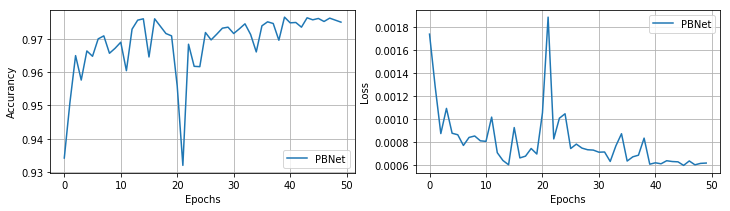

In [0]:
print(loss_history)

print(acc_history)


import numpy as np
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,3))
ax = f.add_subplot(121)
ax.plot(acc_history,label='PBNet')
ax.grid()
ax.set_ylabel('Accurancy')
ax.set_xlabel('Epochs')
ax.legend(loc='lower right')

ax2 = f.add_subplot(122)
ax2.plot(loss_history,label='PBNet')
ax2.grid()
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(loc='upper right')